In [151]:
import pandas_datareader as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
## The below code is used to get the stock data from the websource directly without briging the file to the system.

In [3]:
df=pdr.get_data_yahoo('BCG')

In [4]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-06-06,6730.0,6670.0,6690.0,6730.0,673010.0,6730.0
2017-06-07,7190.0,7000.0,7190.0,7050.0,946660.0,7050.0
2017-06-08,7100.0,6840.0,7100.0,6900.0,415560.0,6900.0
2017-06-09,7000.0,6850.0,6910.0,6990.0,481530.0,6990.0
2017-06-12,7010.0,6880.0,7000.0,6990.0,378990.0,6990.0
...,...,...,...,...,...,...
2022-02-24,24950.0,22950.0,24500.0,23550.0,10041600.0,23550.0
2022-02-25,24500.0,23800.0,24200.0,24000.0,5048000.0,24000.0
2022-02-28,24450.0,23800.0,24000.0,23900.0,4020400.0,23900.0


In [5]:
df_BCG=df.loc['2020-06-01':]

In [6]:
base=np.log(df_BCG['Close'])

<AxesSubplot:xlabel='Date'>

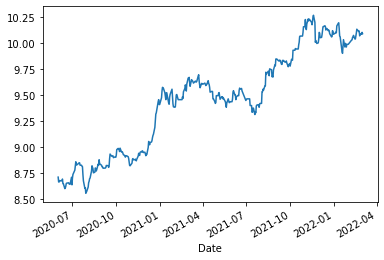

In [7]:
base.plot()

In [8]:
#Calculate rolling mean, exponentially weighted mean

In [9]:
period=7
base_rolling=pd.DataFrame(dict(actual=base,
                               rolling_mean=base.rolling(period).mean(),ewm=base.ewm(span=period).mean()))

In [10]:
base_rolling.head(10)

,actual,rolling_mean,ewm
Date,,,
2020-06-01,8.708496,NaN,8.708496
2020-06-02,8.661977,NaN,8.681914
2020-06-03,8.661977,NaN,8.673293
2020-06-04,8.676161,NaN,8.674342
2020-06-05,8.673027,NaN,8.673911
2020-06-08,8.673027,NaN,8.673642
2020-06-09,8.673027,8.675385,8.673465
2020-06-10,8.690148,8.672763,8.678099
2020-06-11,8.645977,8.670478,8.669417


In [11]:
## checking the data is stationary or not
## We use Augumented dickey fuller (ADF) to check if the price is stationary or not.
result=adfuller(base.dropna())
print(f'ADF stats: {result[0]}')
print(f'p-value: {result[1]}')

ADF stats: -1.047966805051778
p-value: 0.7353702071355802


In [12]:
## the price series is not stationary as the P-value is greater then 0.05
#differentiate to make the data stationary
diff=pd.DataFrame({'actual':base, 'diff1':base.diff(1)}).head(10)
diff['diff2']=diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2020-06-01,8.708496,NaN,NaN
2020-06-02,8.661977,-0.046519,NaN
2020-06-03,8.661977,0.000000,0.046519
2020-06-04,8.676161,0.014184,0.014184
2020-06-05,8.673027,-0.003134,-0.017317
2020-06-08,8.673027,0.000000,0.003134
2020-06-09,8.673027,0.000000,0.000000
2020-06-10,8.690148,0.017121,0.017121
2020-06-11,8.645977,-0.044171,-0.061291


In [13]:
result=adfuller(base.diff(periods=1).dropna())
print(f'ADF stats: {result[0]}')
print(f'p-value: {result[1]}')

ADF stats: -8.175942477588837
p-value: 8.376969310514069e-13


In [14]:
# To find number of differentiation automatically we can use:
from pmdarima.arima.utils import ndiffs
ndiffs(base, test='adf')

1

In [15]:
q=base.diff(periods=1).dropna()
q

Date
2020-06-02   -0.046519
2020-06-03    0.000000
2020-06-04    0.014184
2020-06-05   -0.003134
2020-06-08    0.000000
                ...   
2022-02-24   -0.045651
2022-02-25    0.018928
2022-02-28   -0.004175
2022-03-01    0.018653
2022-03-02   -0.012397
Name: Close, Length: 433, dtype: float64

<AxesSubplot:xlabel='Date'>

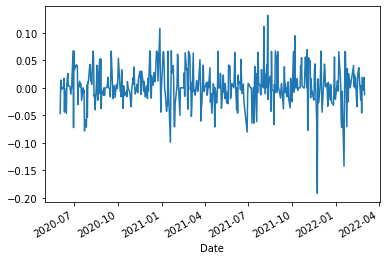

In [16]:
q.plot()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1152x576 with 0 Axes>

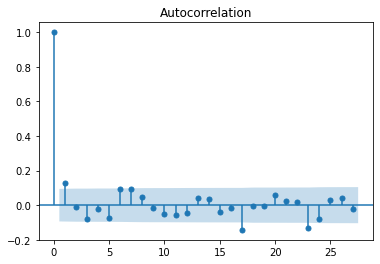

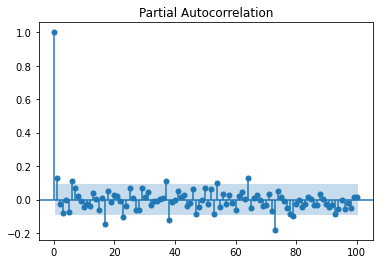

In [18]:
fig=plt.figure(figsize=(16,8))
plot_acf(q)
plot_pacf(q,lags=100);

In [19]:
from statsmodels.tsa.arima_model import ARIMA

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                0
count  433.000000
mean     0.000018
std      0.033715
min     -0.182093
25%     -0.016530
50%     -0.000999
75%      0.015242
max      0.117466


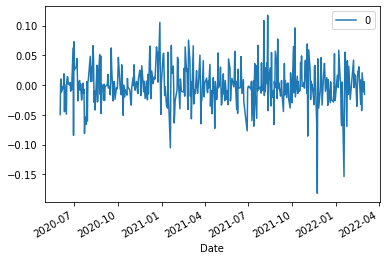

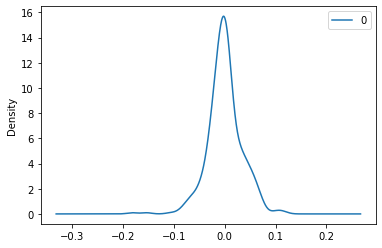

In [20]:
#based on the ACF & PACF plot the p=7, q=1 & d=1
model=ARIMA(base,order=(7,1,1))
model_fit=model.fit(disp=0)
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

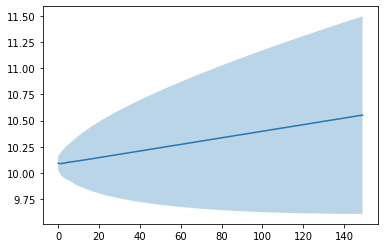

In [21]:
a = ARIMA(base.values, order=(7,1,1))
model_fit = a.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(150)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [22]:
predictions[:10]

array([10.09261828, 10.08863488, 10.09121879, 10.09245069, 10.09840665,
       10.10110356, 10.10421534, 10.10642454, 10.10916803, 10.11171953])

In [23]:
error[:10]

array([0.03367217, 0.05081672, 0.06344427, 0.07272602, 0.08089241,
       0.08721096, 0.09412662, 0.10166016, 0.10917473, 0.11612497])

In [24]:
conf_interval[:10]

array([[10.02662203, 10.15861453],
       [ 9.98903594, 10.18823381],
       [ 9.96687031, 10.21556727],
       [ 9.94991031, 10.23499107],
       [ 9.93986043, 10.25695286],
       [ 9.93017323, 10.2720339 ],
       [ 9.91973056, 10.28870012],
       [ 9.90717428, 10.30567479],
       [ 9.89518948, 10.32314657],
       [ 9.88411878, 10.33932028]])

In [25]:
model.endog

array([-0.04651863,  0.        ,  0.0141835 , -0.00313377,  0.        ,
        0.        ,  0.01712064, -0.04417082, -0.00161548, -0.04628888,
        0.00674506,  0.01666718,  0.02610319,  0.00321618,  0.00320408,
        0.        , -0.0112631 , -0.0016189 , -0.00162161,  0.06747555,
       -0.07235779,  0.06626979,  0.03303528,  0.04194477,  0.04025455,
        0.04000565, -0.03052554,  0.        ,  0.01205552,  0.00133024,
        0.00794742, -0.0013197 , -0.02271308,  0.        , -0.00950447,
       -0.00410128, -0.07833168, -0.05794275, -0.07157547,  0.00504649,
       -0.05341471,  0.01056207,  0.0087194 ,  0.0408219 ,  0.04242137,
        0.01269804,  0.02492392,  0.00613469,  0.06654303,  0.05157958,
       -0.01505811, -0.01249204, -0.03989097,  0.00579683,  0.04105245,
       -0.00695832, -0.02260031,  0.01418474,  0.05213786, -0.01075227,
        0.0526441 , -0.03788898, -0.00400285, -0.01075227, -0.01360575,
        0.        , -0.0137935 , -0.0013894 ,  0.0013894 ,  0.00

In [26]:
# The 1.96 is used to use the 95% of the error rate with the prediction values
(predictions+1.96*error)[:10]

array([10.15861574, 10.18823564, 10.21556955, 10.23499369, 10.25695578,
       10.27203704, 10.28870351, 10.30567846, 10.3231505 , 10.33932446])

In [27]:
(predictions-1.96*error)[:10]

array([10.02662082,  9.98903411,  9.96686803,  9.94990769,  9.93985752,
        9.93017009,  9.91972717,  9.90717062,  9.89518555,  9.88411459])

predicted=9.716949, actual=9.683464
predicted=9.687443, actual=9.749753
predicted=9.755321, actual=9.746834
predicted=9.758072, actual=9.740969
predicted=9.733571, actual=9.674074
predicted=9.678531, actual=9.680344
predicted=9.672685, actual=9.670925
predicted=9.687561, actual=9.738023
predicted=9.738565, actual=9.786954
predicted=9.811252, actual=9.778491
predicted=9.763783, actual=9.844268
predicted=9.862986, actual=9.844268
predicted=9.841252, actual=9.844268
predicted=9.844180, actual=9.825526
predicted=9.828332, actual=9.825526
predicted=9.823513, actual=9.833601
predicted=9.842977, actual=9.830917
predicted=9.830813, actual=9.792556
predicted=9.791860, actual=9.792556
predicted=9.794294, actual=9.830917
predicted=9.843883, actual=9.822820
predicted=9.822656, actual=9.830917
predicted=9.835720, actual=9.814656
predicted=9.815455, actual=9.814656
predicted=9.815156, actual=9.814656
predicted=9.821180, actual=9.825526
predicted=9.827911, actual=9.806426
predicted=9.808948, actual=9

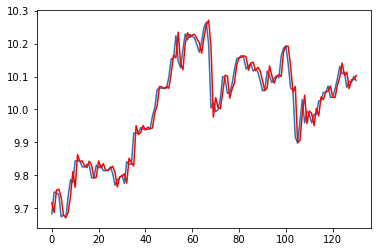

In [154]:
x = base.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test)
plt.plot(predictions, color='red')

In [29]:
result=pd.DataFrame(base)[train_size:]
result.columns=['actual']
result['prediction']=predictions
z=result
z

,actual,prediction
Date,,
2021-08-18,9.683464,9.716949
2021-08-19,9.749753,9.687443
2021-08-20,9.746834,9.755321
2021-08-23,9.740969,9.758072
2021-08-24,9.674074,9.733571
...,...,...
2022-02-24,10.066881,10.113385
2022-02-25,10.085809,10.063208
2022-02-28,10.081634,10.090092


In [30]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+DateOffset(days=x)for x in range(0,24)]

In [31]:
future_datest_df=pd.DataFrame(index=future_dates[1:])

In [32]:
future_datest_df.tail()

""
2022-03-21
2022-03-22
2022-03-23
2022-03-24
2022-03-25


In [33]:
#predictions, error, conf_interval
a,b,c=model_fit.forecast(23)

In [34]:
future_datest_df=future_datest_df.reset_index()

In [35]:
future_datest_df["prediction"]=a

In [36]:
future_datest_df=future_datest_df.set_index(['index'])

In [37]:
future_datest_df

,prediction
index,
2022-03-03,10.102697
2022-03-04,10.111400
2022-03-05,10.110342
2022-03-06,10.115413
2022-03-07,10.116065
2022-03-08,10.120438
2022-03-09,10.122673
2022-03-10,10.126803
2022-03-11,10.129514


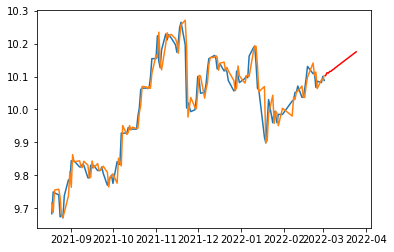

In [38]:
plt.plot(z)
plt.plot(future_datest_df, color='red')

# Stock market model with categorical variable.

In [39]:
#import all the year data
if os.path.exists("bcg.csv"):
    bcg = pd.read_csv("bcg.csv", index_col=0)
else:
    bcg = yf.Ticker("BCG")
    bcg = bcg.history(period="max")
    bcg.to_csv("bcg.csv")

In [40]:
bcg

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-07-16,15277.799805,16666.699219,15000.000000,16574.099609,237812,0,0
2015-07-17,16574.099609,17685.199219,16296.299805,17592.599609,171234,0,0
2015-07-20,17592.599609,18796.300781,17500.000000,18518.500000,151702,0,0
2015-07-21,18425.900391,18425.900391,17222.199219,17222.199219,17689,0,0
2015-07-22,16018.500000,16018.500000,16018.500000,16018.500000,200,0,0
...,...,...,...,...,...,...,...
2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600,0,0
2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000,0,0
2022-02-28,24000.000000,24450.000000,23800.000000,23900.000000,4020400,0,0


In [41]:
del bcg['Dividends']
del bcg['Stock Splits']

In [42]:
bcg

,Open,High,Low,Close,Volume
Date,,,,,
2015-07-16,15277.799805,16666.699219,15000.000000,16574.099609,237812
2015-07-17,16574.099609,17685.199219,16296.299805,17592.599609,171234
2015-07-20,17592.599609,18796.300781,17500.000000,18518.500000,151702
2015-07-21,18425.900391,18425.900391,17222.199219,17222.199219,17689
2015-07-22,16018.500000,16018.500000,16018.500000,16018.500000,200
...,...,...,...,...,...
2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600
2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000
2022-02-28,24000.000000,24450.000000,23800.000000,23900.000000,4020400


<AxesSubplot:xlabel='Date'>

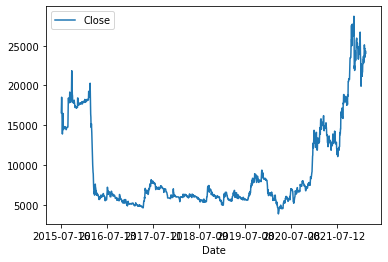

In [43]:
bcg.plot.line(y='Close')

In [44]:
bcg['Tomorrow']=bcg['Close'].shift(-1)

In [45]:
bcg['Target']=(bcg['Tomorrow']>bcg['Close']).astype(int)

In [46]:
bcg

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2015-07-16,15277.799805,16666.699219,15000.000000,16574.099609,237812,17592.599609,1
2015-07-17,16574.099609,17685.199219,16296.299805,17592.599609,171234,18518.500000,1
2015-07-20,17592.599609,18796.300781,17500.000000,18518.500000,151702,17222.199219,0
2015-07-21,18425.900391,18425.900391,17222.199219,17222.199219,17689,16018.500000,0
2015-07-22,16018.500000,16018.500000,16018.500000,16018.500000,200,14907.400391,0
...,...,...,...,...,...,...,...
2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600,24000.000000,1
2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000,23900.000000,0
2022-02-28,24000.000000,24450.000000,23800.000000,23900.000000,4020400,24350.000000,1


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [48]:
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

train=bcg.iloc[:-100]
test=bcg.iloc[-100:]

predictors=['Open','High',"Low",'Close','Volume']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [49]:
pred=model.predict(test[predictors])
pred=pd.Series(pred, index=test.index)
precision_score(test['Target'], pred)

0.0

In [50]:
pred.tail()

Date
2022-02-24    0
2022-02-25    0
2022-02-28    0
2022-03-01    0
2022-03-02    0
dtype: int64

In [51]:
combine=pd.concat([test['Target'], pred], axis=1)

<AxesSubplot:xlabel='Date'>

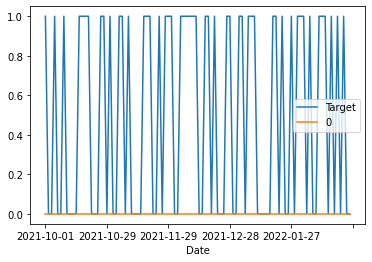

In [52]:
combine.plot()

In [53]:
def predict(train, test,predictors, models):
    model.fit(train[predictors], train["Target"])
    pred=model.predict(test[predictors])
    pred=pd.Series(pred, index=test.index, name='Predictions')
    combine=pd.concat([test['Target'], pred], axis=1)
    return combine

In [54]:
def backtest(data, model, predictors, start=500, step=125):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions =predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [55]:
predictions = backtest(bcg, model, predictors)

In [56]:
predictions["Predictions"].value_counts()

0    1139
1      19
Name: Predictions, dtype: int64

In [57]:
precision_score(predictions["Target"], predictions["Predictions"])

0.3157894736842105

In [58]:
predictions["Predictions"].value_counts()/predictions.shape[0]

0    0.983592
1    0.016408
Name: Predictions, dtype: float64

In [59]:
horizons=[2,5,30,90,200]
new_predictors=[]
for horizon in horizons:
    rolling_average=bcg.rolling(horizon).mean()
    ratio_column=f"Close_ratio_{horizon}"
    bcg[ratio_column]=bcg['Close']/rolling_average['Close']
    trend_column=f"Trend_{horizon}"
    bcg[trend_column]=bcg.shift(1).rolling(horizon).sum()['Target']
    new_predictors+=[ratio_column,trend_column]

In [60]:
bcg

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_ratio_2,Trend_2,Close_ratio_5,Trend_5,Close_ratio_30,Trend_30,Close_ratio_90,Trend_90,Close_ratio_200,Trend_200
Date,,,,,,,,,,,,,,,,,
2015-07-16,15277.799805,16666.699219,15000.000000,16574.099609,237812,17592.599609,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-17,16574.099609,17685.199219,16296.299805,17592.599609,171234,18518.500000,1,1.029810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-20,17592.599609,18796.300781,17500.000000,18518.500000,151702,17222.199219,0,1.025640,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-21,18425.900391,18425.900391,17222.199219,17222.199219,17689,16018.500000,0,0.963730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-22,16018.500000,16018.500000,16018.500000,16018.500000,200,14907.400391,0,0.963788,0.0,0.932111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600,24000.000000,1,0.977178,1.0,0.964769,3.0,1.015962,15.0,0.980215,46.0,1.244418,93.0
2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000,23900.000000,0,1.009464,1.0,0.984817,3.0,1.035748,16.0,0.997331,47.0,1.264604,93.0
2022-02-28,24000.000000,24450.000000,23800.000000,23900.000000,4020400,24350.000000,1,0.997912,1.0,0.990468,2.0,1.034408,15.0,0.991779,46.0,1.255812,93.0


In [61]:
bcg.dropna(inplace=True)

In [62]:
bcg

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_ratio_2,Trend_2,Close_ratio_5,Trend_5,Close_ratio_30,Trend_30,Close_ratio_90,Trend_90,Close_ratio_200,Trend_200
Date,,,,,,,,,,,,,,,,,
2016-05-02,6203.700195,6203.700195,6203.700195,6203.700195,0,6203.700195,0,1.000000,0.0,0.988200,1.0,0.883905,7.0,0.444002,26.0,0.396602,63.0
2016-05-03,6203.700195,6203.700195,6203.700195,6203.700195,0,6018.520020,0,1.000000,0.0,0.994065,0.0,0.900134,7.0,0.448094,26.0,0.398051,62.0
2016-05-04,6203.700195,6203.700195,6018.520020,6018.520020,891216,6018.520020,0,0.984849,0.0,0.973054,0.0,0.887574,7.0,0.438860,25.0,0.387724,61.0
2016-05-05,6111.109863,6111.109863,5925.930176,6018.520020,608882,6018.520020,0,1.000000,0.0,0.981874,0.0,0.901109,7.0,0.443148,24.0,0.389128,61.0
2016-05-06,6111.109863,6111.109863,5925.930176,6018.520020,291654,5740.740234,0,1.000000,0.0,0.987842,0.0,0.914206,7.0,0.447487,24.0,0.390390,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-23,24750.000000,25100.000000,24500.000000,24650.000000,4880900,23550.000000,0,1.002033,1.0,1.010660,4.0,1.062118,16.0,1.027449,46.0,1.306392,94.0
2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600,24000.000000,1,0.977178,1.0,0.964769,3.0,1.015962,15.0,0.980215,46.0,1.244418,93.0
2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000,23900.000000,0,1.009464,1.0,0.984817,3.0,1.035748,16.0,0.997331,47.0,1.264604,93.0


In [63]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [64]:
def predict(train, test,predictors, models):
    model.fit(train[predictors], train["Target"])
    preds=model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6]=1
    preds[preds<.6]=0
    preds=pd.Series(preds, index=test.index, name='Predictions')
    combine=pd.concat([test['Target'], preds], axis=1)
    return combine

In [65]:
predictions=backtest(bcg,model,new_predictors)

In [66]:
predictions["Predictions"].value_counts()

0.0    936
1.0     21
Name: Predictions, dtype: int64

In [67]:
precision_score(predictions["Target"], predictions["Predictions"])

0.38095238095238093

In [68]:
predictions["Predictions"].value_counts()/predictions.shape[0]

0.0    0.978056
1.0    0.021944
Name: Predictions, dtype: float64

# Stock market prediction with Xgboost regression

In [69]:
if os.path.exists("bcg.csv"):
    stock = pd.read_csv("bcg.csv", index_col=0)
else:
    stock = yf.Ticker("BCG")
    stock = stock.history(period="max")
    stock.to_csv("bcg.csv")

In [74]:
del stock['Dividends']
del stock['Stock Splits']

In [76]:
stock['Target']=stock['Close'].shift(-1)

In [78]:
stock.dropna(inplace=True)

In [92]:
stock=stock.reset_index()

In [129]:
stock

,Date,Open,High,Low,Close,Volume,Target
0,2015-07-16,15277.799805,16666.699219,15000.000000,16574.099609,237812,17592.599609
1,2015-07-17,16574.099609,17685.199219,16296.299805,17592.599609,171234,18518.500000
2,2015-07-20,17592.599609,18796.300781,17500.000000,18518.500000,151702,17222.199219
3,2015-07-21,18425.900391,18425.900391,17222.199219,17222.199219,17689,16018.500000
4,2015-07-22,16018.500000,16018.500000,16018.500000,16018.500000,200,14907.400391
...,...,...,...,...,...,...,...
1652,2022-02-23,24750.000000,25100.000000,24500.000000,24650.000000,4880900,23550.000000
1653,2022-02-24,24500.000000,24950.000000,22950.000000,23550.000000,10041600,24000.000000
1654,2022-02-25,24200.000000,24500.000000,23800.000000,24000.000000,5048000,23900.000000
1655,2022-02-28,24000.000000,24450.000000,23800.000000,23900.000000,4020400,24350.000000


In [93]:
features = ['Open', 'High','Low','Close','Volume']
label = 'Target'
train_df=stock.iloc[:-100]
test_df=stock.iloc[-100:]
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [102]:
model = XGBRegressor(objective='reg:squarederror',n_estimators=900)
model.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:5916.41895	validation_1-mae:18406.13477
[1]	validation_0-mae:4151.76611	validation_1-mae:14624.50488
[2]	validation_0-mae:2914.30688	validation_1-mae:11959.97754
[3]	validation_0-mae:2046.18982	validation_1-mae:10045.61914
[4]	validation_0-mae:1436.01953	validation_1-mae:8673.96973
[5]	validation_0-mae:1008.82867	validation_1-mae:7538.48633
[6]	validation_0-mae:709.17419	validation_1-mae:6583.07617
[7]	validation_0-mae:503.38721	validation_1-mae:5865.74609
[8]	validation_0-mae:363.83984	validation_1-mae:5258.21875
[9]	validation_0-mae:270.94580	validation_1-mae:4790.33105
[10]	validation_0-mae:211.70406	validation_1-mae:4398.29736
[11]	validation_0-mae:175.53220	validation_1-mae:4088.54834
[12]	validation_0-mae:153.31894	validation_1-mae:4012.39819
[13]	validation_0-mae:141.28203	validation_1-mae:3939.93164
[14]	validation_0-mae:133.79921	validation_1-mae:3870.70435
[15]	validation_0-mae:129.64905	validation_1-mae:3721.43945
[16]	validation_0-mae:127.29546	validati

[138]	validation_0-mae:35.90493	validation_1-mae:3508.32056
[139]	validation_0-mae:35.71762	validation_1-mae:3508.32056
[140]	validation_0-mae:35.43534	validation_1-mae:3508.07373
[141]	validation_0-mae:35.18003	validation_1-mae:3507.07617
[142]	validation_0-mae:34.83224	validation_1-mae:3507.36865
[143]	validation_0-mae:34.52039	validation_1-mae:3507.34180
[144]	validation_0-mae:34.19426	validation_1-mae:3507.33447
[145]	validation_0-mae:33.88963	validation_1-mae:3507.29150
[146]	validation_0-mae:33.31574	validation_1-mae:3507.15137
[147]	validation_0-mae:33.04261	validation_1-mae:3507.53149
[148]	validation_0-mae:32.82834	validation_1-mae:3507.67603
[149]	validation_0-mae:32.58053	validation_1-mae:3507.87183
[150]	validation_0-mae:32.21757	validation_1-mae:3507.81934
[151]	validation_0-mae:31.80016	validation_1-mae:3507.75928
[152]	validation_0-mae:31.48891	validation_1-mae:3507.98560
[153]	validation_0-mae:31.21864	validation_1-mae:3507.93311
[154]	validation_0-mae:31.01115	validati

[275]	validation_0-mae:13.05923	validation_1-mae:3505.83838
[276]	validation_0-mae:12.98116	validation_1-mae:3505.82056
[277]	validation_0-mae:12.92216	validation_1-mae:3505.80005
[278]	validation_0-mae:12.86382	validation_1-mae:3505.80054
[279]	validation_0-mae:12.81793	validation_1-mae:3505.91992
[280]	validation_0-mae:12.75888	validation_1-mae:3505.91211
[281]	validation_0-mae:12.66831	validation_1-mae:3505.92554
[282]	validation_0-mae:12.62545	validation_1-mae:3505.93945
[283]	validation_0-mae:12.56211	validation_1-mae:3505.94751
[284]	validation_0-mae:12.49686	validation_1-mae:3505.93262
[285]	validation_0-mae:12.39473	validation_1-mae:3505.91089
[286]	validation_0-mae:12.36640	validation_1-mae:3505.90747
[287]	validation_0-mae:12.28674	validation_1-mae:3505.90405
[288]	validation_0-mae:12.25031	validation_1-mae:3505.88355
[289]	validation_0-mae:12.20152	validation_1-mae:3505.89868
[290]	validation_0-mae:12.13661	validation_1-mae:3505.93408
[291]	validation_0-mae:12.09640	validati

[413]	validation_0-mae:6.87613	validation_1-mae:3505.29761
[414]	validation_0-mae:6.85586	validation_1-mae:3505.34375
[415]	validation_0-mae:6.83466	validation_1-mae:3505.33472
[416]	validation_0-mae:6.79268	validation_1-mae:3505.33057
[417]	validation_0-mae:6.76154	validation_1-mae:3505.32495
[418]	validation_0-mae:6.74353	validation_1-mae:3505.32495
[419]	validation_0-mae:6.72063	validation_1-mae:3505.32349
[420]	validation_0-mae:6.69024	validation_1-mae:3505.31177
[421]	validation_0-mae:6.67253	validation_1-mae:3505.28027
[422]	validation_0-mae:6.64719	validation_1-mae:3505.27490
[423]	validation_0-mae:6.61339	validation_1-mae:3505.27490
[424]	validation_0-mae:6.60137	validation_1-mae:3505.25537
[425]	validation_0-mae:6.59261	validation_1-mae:3505.25537
[426]	validation_0-mae:6.57040	validation_1-mae:3505.25244
[427]	validation_0-mae:6.54899	validation_1-mae:3505.25244
[428]	validation_0-mae:6.53218	validation_1-mae:3505.28320
[429]	validation_0-mae:6.51853	validation_1-mae:3505.287

[552]	validation_0-mae:4.72937	validation_1-mae:3504.76562
[553]	validation_0-mae:4.72256	validation_1-mae:3504.76587
[554]	validation_0-mae:4.71614	validation_1-mae:3504.76587
[555]	validation_0-mae:4.70737	validation_1-mae:3504.74756
[556]	validation_0-mae:4.69891	validation_1-mae:3504.74756
[557]	validation_0-mae:4.69296	validation_1-mae:3504.81738
[558]	validation_0-mae:4.68436	validation_1-mae:3504.84253
[559]	validation_0-mae:4.67548	validation_1-mae:3504.84253
[560]	validation_0-mae:4.66259	validation_1-mae:3504.84058
[561]	validation_0-mae:4.65462	validation_1-mae:3504.83447
[562]	validation_0-mae:4.64877	validation_1-mae:3504.82935
[563]	validation_0-mae:4.64285	validation_1-mae:3504.82935
[564]	validation_0-mae:4.63352	validation_1-mae:3504.82739
[565]	validation_0-mae:4.62637	validation_1-mae:3504.82324
[566]	validation_0-mae:4.61909	validation_1-mae:3504.83179
[567]	validation_0-mae:4.61054	validation_1-mae:3504.83179
[568]	validation_0-mae:4.60405	validation_1-mae:3504.828

[691]	validation_0-mae:3.97480	validation_1-mae:3504.77222
[692]	validation_0-mae:3.97321	validation_1-mae:3504.77222
[693]	validation_0-mae:3.96979	validation_1-mae:3504.76465
[694]	validation_0-mae:3.96874	validation_1-mae:3504.76318
[695]	validation_0-mae:3.95887	validation_1-mae:3504.76318
[696]	validation_0-mae:3.95443	validation_1-mae:3504.76318
[697]	validation_0-mae:3.95067	validation_1-mae:3504.76318
[698]	validation_0-mae:3.94759	validation_1-mae:3504.76318
[699]	validation_0-mae:3.94465	validation_1-mae:3504.76440
[700]	validation_0-mae:3.94328	validation_1-mae:3504.76465
[701]	validation_0-mae:3.93989	validation_1-mae:3504.76489
[702]	validation_0-mae:3.93917	validation_1-mae:3504.76489
[703]	validation_0-mae:3.93747	validation_1-mae:3504.76489
[704]	validation_0-mae:3.93541	validation_1-mae:3504.77881
[705]	validation_0-mae:3.93446	validation_1-mae:3504.77124
[706]	validation_0-mae:3.93147	validation_1-mae:3504.77124
[707]	validation_0-mae:3.92823	validation_1-mae:3504.771

[830]	validation_0-mae:3.69578	validation_1-mae:3504.74707
[831]	validation_0-mae:3.69527	validation_1-mae:3504.74707
[832]	validation_0-mae:3.69423	validation_1-mae:3504.74707
[833]	validation_0-mae:3.69125	validation_1-mae:3504.74707
[834]	validation_0-mae:3.69034	validation_1-mae:3504.74707
[835]	validation_0-mae:3.68958	validation_1-mae:3504.74707
[836]	validation_0-mae:3.68851	validation_1-mae:3504.74707
[837]	validation_0-mae:3.68763	validation_1-mae:3504.74683
[838]	validation_0-mae:3.68682	validation_1-mae:3504.74683
[839]	validation_0-mae:3.68605	validation_1-mae:3504.74683
[840]	validation_0-mae:3.68432	validation_1-mae:3504.74683
[841]	validation_0-mae:3.68336	validation_1-mae:3504.74854
[842]	validation_0-mae:3.68246	validation_1-mae:3504.74854
[843]	validation_0-mae:3.68194	validation_1-mae:3504.75000
[844]	validation_0-mae:3.68168	validation_1-mae:3504.75073
[845]	validation_0-mae:3.68083	validation_1-mae:3504.75073
[846]	validation_0-mae:3.68004	validation_1-mae:3504.748

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
predictions = model.predict(X_test)

In [149]:
predictions

array([17988.357, 17782.404, 18283.426, 18475.01 , 19650.582, 19722.47 ,
       19586.793, 19586.793, 20378.947, 20370.857, 20199.074, 20386.533,
       20199.074, 20352.842, 20379.346, 20422.475, 20378.62 , 20199.074,
       20199.074, 20199.074, 20378.62 , 20419.506, 20199.074, 20419.88 ,
       20419.88 , 20422.475, 20379.346, 20376.285, 20378.62 , 20372.38 ,
       20372.107, 20378.62 , 20396.78 , 20378.62 , 20371.191, 20386.533,
       20422.475, 20379.346, 20361.838, 20378.62 , 20371.191, 20379.346,
       20396.78 , 20419.88 , 20419.506, 20419.88 , 20379.346, 20531.852,
       20347.543, 20378.479, 20378.62 , 20352.842, 20378.479, 20361.838,
       20746.695, 20370.857, 20506.246, 20746.695, 20378.479, 20344.662,
       20256.541, 20693.586, 20344.662, 20159.496, 20218.793, 20506.246,
       20344.662, 20693.586, 20422.475, 20419.783, 20379.346, 20386.533,
       20386.533, 20361.838, 18840.764, 19663.393, 20748.65 , 20344.662,
       20531.852, 20205.148, 20200.15 , 20193.656, 

In [142]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


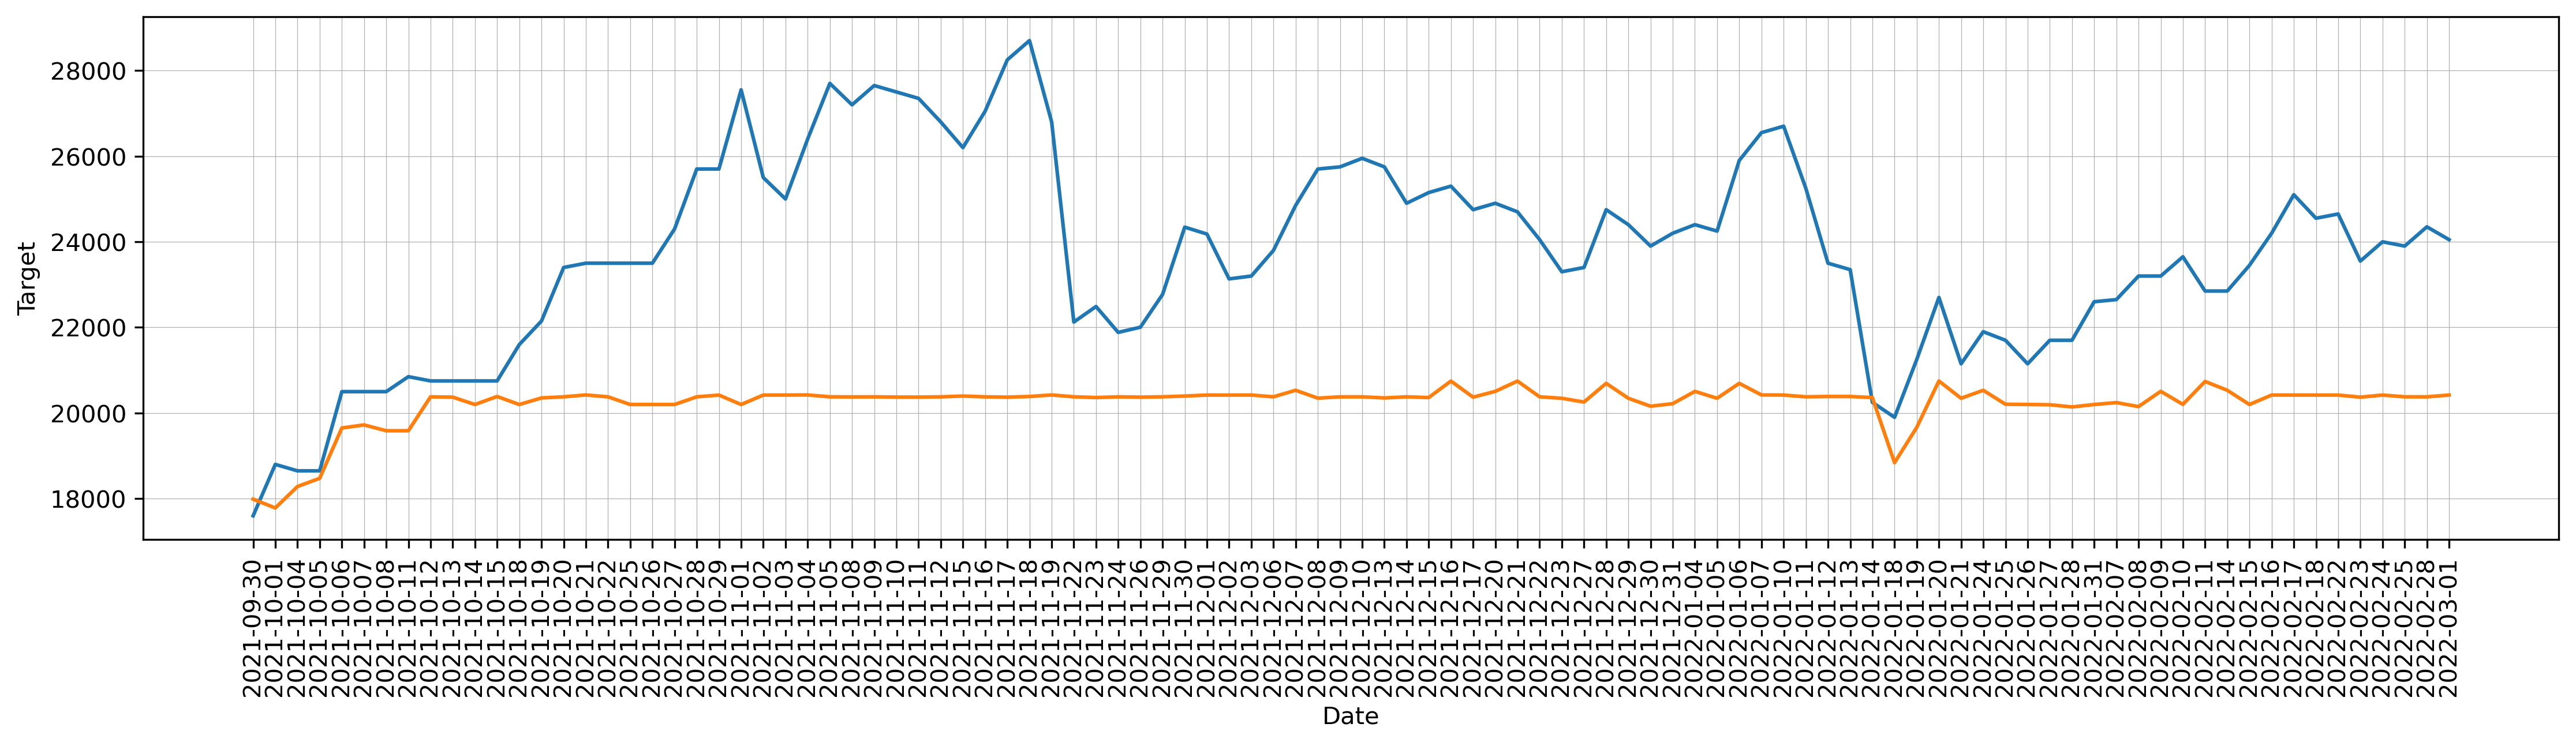

In [143]:
plt.rcParams.update({'figure.figsize': (18, 4), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=stock.tail(100), x='Date', y='Target')
sns.lineplot(data=test_df, x='Date', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [123]:
test_df

,Date,Open,High,Low,Close,Volume,Target,predictions
0,2021-09-30,18200.0,18350.0,17900.0,18050.0,2240400,17600.0,17988.357422
1,2021-10-01,18000.0,18200.0,17600.0,17600.0,3327200,18800.0,17782.404297
2,2021-10-04,17650.0,18800.0,17600.0,18800.0,1043748736,18650.0,18283.425781
3,2021-10-05,19200.0,19400.0,18600.0,18650.0,2348700,18650.0,18475.009766
4,2021-10-06,18650.0,18650.0,18650.0,18650.0,0,20500.0,19650.582031
...,...,...,...,...,...,...,...,...
95,2022-02-23,24750.0,25100.0,24500.0,24650.0,4880900,23550.0,20371.191406
96,2022-02-24,24500.0,24950.0,22950.0,23550.0,10041600,24000.0,20419.880859
97,2022-02-25,24200.0,24500.0,23800.0,24000.0,5048000,23900.0,20379.345703
98,2022-02-28,24000.0,24450.0,23800.0,23900.0,4020400,24350.0,20378.619141


In [168]:
error=sqrt(mean_squared_error(test_df['predictions'],y_test))

In [169]:
error

4036.030045642438